Porto Seguro는 브라질의 자동차 보험회사입니다.  
본 캐글의 목적은 어떤 차주가 내년에 보험 청구를 할 확률을 예측하는 것입니다.  
  
데이터는 59만개의 훈련 데이터와 89만개의 테스트 데이터로 구성되어 있습니다.  
테스트 데이터가 훈련 데이터보다 많습니다.  
그리고 이 데이터는 다음과 같은 특징이 있습니다.  

- 결측치값이 -1로 되어 있습니다.
- Feature가 무엇을 뜻하는지 알수 없습니다.(비식별화 처리)  
- feature들이 그루핑되어 있습니다.
    - ind: 정수값 매핑
    - reg: region(지역과 관련된 변수로 예상합니다.)
    - car: 차에 관련한 변수
    - calc: 실수값(어떤 값들이 임의로 계산된 값이라고 예상합니다.)
- bin은 binary feature, cat은 categorical feature에 해당합니다.
- 나머지는 연속형 변수 아니면 순서형 변수 입니다.
- 타겟값은 이전에 보험 청구가 있었으면 1, 아니면 0으로 이루어져 있습니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns',180)

# 1. Loading data

In [2]:
train = pd.read_csv('../porto_train.csv')
test = pd.read_csv('../porto_test.csv')

In [3]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


우리가 주목해야 할 점은 다음과 같습니다.
- 이진변수
- 범주 값이 정수인 범주형 변수
- integer 또는 float 값을 가진 다른 변수
- -1로 이루어진 null 값
- 타겟 변수와 id 변수

<br>

train 데이터 안의 columns과 rows의 수를 봅시다.

In [4]:
train.shape

(595212, 59)

In [5]:
train.drop_duplicates()
train.shape

(595212, 59)

In [6]:
test.shape

(892816, 58)

train 데이터셋에는 59개의 column과 595212개의 데이터가 있습니다.  
test 데이터셋에는 58개의 column과 892816개의 데이터가 존재하고 있습니다.  
  
train 데이터보다 test 데이터셋이 더 많은 특이한 경우입니다.

<br>

이제 데이터의 유형에 대해 살펴볼 것입니다.  
나중에 우리는 14개의 categorical 변수에 대해 dummy 변수화를 시킬 수 있을 것입니다.  
bin 변수는 이미 이진분류이기 때문에 dummy변수화를 시킬 필요가 없습니다.

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

데이터셋에 null값이 존재하지 않습니다.  
그 이유는 앞서 말했듯이 null값을 -1로 대체하였기 때문입니다.

# 2. Metadata
데이터 관리를 용이하게 위해서 우리는 DataFrame안에 각각의 변수의 관한 meta정보를 담을 것입니다.  
이 작업은 분석 뿐만이 아니라 시각화, 모델링등과 같은 곳에서 특정한 변수 선택을 할 때 도움이 됩니다.

<br>

- 우리는 다음을 기준으로 Metadata를 나눌 것입니다.  
    - 데이터의 역할: input, ID, target
    - 데이터의 level: nominal, interval, ordinal, binary (명목, 간격, 순서, 이진)
    - 데이터를 쓸지 안쓸지: True or False(아래의 경우는 id 변수만 버리고 나머지는 가져감)
    - 데이터의 타입: int, float, str

In [8]:
data = []
for f in train.columns:
    # 데이터의 역할을 지정 (독립변수, 종속변수, id)
    if f == 'target':
        role = 'target'
    elif f == 'id':
        role = 'id'
    else:
        role = 'input'
        
    # 데이터의 level을 지정 (명목변수, 간격변수, 순서변수)
    if 'bin' in f or f == 'target':
        level='binary'
    elif 'cat' in f or f == 'id':
        level='nominal'
    elif train[f].dtype == float:
        level = 'interval'
    elif train[f].dtype == 'int64':
        level = 'ordinal'
        
    # keep 군집을 id를 제외한 모든 변수들을 위해 True로 초기화한다.
    keep = True
    if f == 'id':
        keep = False
        
    dtype = train[f].dtype
    
    # DataFrame으로 만들기 위해 리스트에 append하기 전에 딕셔너리 타입으로 만들어주었음
    f_dict = {
        'varname': f,
        'role': role,
        'level': level,
        'keep': keep,
        'dtype': dtype
    }
    data.append(f_dict)
# 변수의 이름을 인덱스로 하는 데이터프레임을 만들어줌
meta = pd.DataFrame(data, columns = ['varname', 'role', 'level', 'keep', 'dtype'])
meta.set_index('varname', inplace=True)
meta

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,int64
ps_ind_05_cat,input,nominal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


meta라는 DataFrame을 만든 이유는 자료의 column들이 많기 때문입니다.  
더불어 이 column들은 비식별화되어 있어 어떠한 column이 어떠한 속성을 가지고 있는지를 쉽게 알지 못합니다.  

- 다음은meta DataFrame을 사용한 예시입니다.
    - drop하지 않은 명목변수를 추출하는 예

In [10]:
meta[(meta.level == 'nominal') & (meta.keep)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

역할과 level에 따른 변수들의 수는 다음과 같아 나타낼 수 있습니다.

In [11]:
pd.DataFrame({'count':meta.groupby(['role', 'level'])['role'].size()}).reset_index()

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordinal,16
5,target,binary,1


# 3. 통계적 분석
우리는 *decribe* method를 통해 DataFrame의 통계량을 분석할 수 있습니다.  
그러나 categorical 변수나 id 변수에 통계량(평균, 표준편차 등)을 구할 수 없습니다.  
이러한 categorical 변수는 나중에 시각화하기로 합시다.  

<br>

다행히 우리는 meta DataFrame을 통해 쉽게 통계량 분석에 필요한 변수들을 선택하여 분석할 수 있습니다.  
각각의 데이터의 타입대로 *describe*를 실행하여 봅시다.

## 3_1. 순서형 변수

In [12]:
v = meta[(meta.level == 'interval') & (meta.keep)].index
train[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


**reg variables**  
- 오직 ps_reg_03만이 결측치 값을 가지고 있습니다.
- 범위(최소값과 최대값)은 변수간마다 다릅니다. 우리는 scaling을 할수 있겠지만 우리가 사용할 분류기에 따라 다릅니다.  

**cat variables**  
- ps_cat12와 ps_car14에 결측치 값을 가지고 있습니다.
- 이 속성 또한 스케일이 필요할 수 있습니다.  

**calc variables**  
- 결측치를 가지고 있지 않습니다.
- 최대값이 9를 가진 어떠한 일정한 비율을 가지고 있는 것으로 보입니다.
- calc 변수는 매우 비슷한 분포를 보입니다.  

전체적으로 순서형 변수들의 범위가 작은 것을 알수 있습니다.  
아마도 데이터 비식별화를 위해 몇가지의 변환(ex. log transformation)이 미리 적용된 것 같습니다.

## 3_2. 순위 변수

In [13]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
train[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


- ps_car_11 column만이 결측치를 가지고 있습니다.
- 다른 범위를 가지고 있는 column들은 scaling이 필요할 수 있습니다.

## 3_3. 이진분류

In [14]:
v = meta[(meta.level == 'binary') & (meta.keep)].index
train[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- target column의 평균이 3.645%로 **매우 불균형한 데이터입니다.**
- 모든 이진분류 column들의 평균이 0.5 이하의 데이터입니다.
    - 이를 보고 우리는 대다수의 변수들이 0이라는 사실을 발견할 수 있습니다.

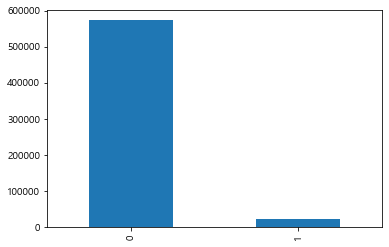

In [15]:
train['target'].value_counts().plot(kind='bar');

# 4. imbalabced한 데이터 다루기
- 앞에서 언급한 바와 같이 target=1인 관측치의 비율이 target=0보다 훨씬 작습니다.
- 따라서 정확도는 매우 높지만 target=1의 값을 찾는 것에는 매우 힘들 것입니다.
    - 이 데이터는 보험료를 많이 부과할 사람들을 찾는 대회입니다.
    - 대다수의 사람들은 정상적인 보험료를 납부하겠지만 사고를 내거나 사기 경력이 있는 것과 같은 매우 빈도수를 가진 사람들을 찾는 것에 주 목표가 있습니다.
- 이러한 문제를 해결하기 위한 두 가지 가능한 전력은 다음과 같습니다.

<br>

- target=1값을 가진 관측치를 oversampling
- target=0값을 가진 관측치를 undersampling

<br>

이 데이터의 크기가 꽤 크므로 undersmapling을 이용하겠습니다.  
(대다수의 경우엔 oversampling을 사용함 - undersampling은 정보의 유실이 발생하기 때문)

In [16]:
desired_apriori = 0.1

# target 값마다 인덱스 값을 가져온다.
idx_0 = train[train.target == 0].index
idx_1 = train[train.target == 1].index

# target 값마다의 관측치 수를 가져온다.
nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])

# undersampling 비율과 target=0을 가진 관측치의 수를 계산한다.
undersampling_rate = ((1-desired_apriori) * nb_1) / (nb_0 * desired_apriori)
undersampled_nb_0 = int(undersampling_rate * nb_0)
print('target=0 값을 가진 undersampling 관측값의 비율: {}'.format(undersampling_rate))
print('undersampling 후의 target=0 값을 가진 관측치의 수: {}'.format(undersampled_nb_0))

# 앞서 변수로 desired_apriori에서 선언했던 값들 중에서 랜덤하게 target= 0 값을 가진 관측값을 선택한다.
undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

# 나머지 인덱스를 가지고 list를 생성
idx_list = list(undersampled_idx) + list(idx_1)

# DataFrame으로 되돌린다.
train= train.loc[idx_list].reset_index(drop=True)

target=0 값을 가진 undersampling 관측값의 비율: 0.34043569687437886
undersampling 후의 target=0 값을 가진 관측치의 수: 195246


In [17]:
train.shape

(216940, 59)

# 5. 데이터 품질 체크?
## 5_1. 결측치 체크
- 결측치는 -1로 나타나 있다.

In [18]:
vars_with_missing = []

for f in train.columns:
    missings = train[train[f] == -1][f].count()
    if missings > 0:
        vars_with_missing.append(f)
        missings_prec = missings/train.shape[0]
        
        print('변수 {} 에 {}개({:.2%})의 결측치가 존재합니다.'.format(f, missings, missings_prec))

print('')        
print('전체적으로, {}개의 변수에 결측치가 존재합니다.'.format(len(vars_with_missing)))

변수 ps_ind_02_cat 에 103개(0.05%)의 결측치가 존재합니다.
변수 ps_ind_04_cat 에 51개(0.02%)의 결측치가 존재합니다.
변수 ps_ind_05_cat 에 2256개(1.04%)의 결측치가 존재합니다.
변수 ps_reg_03 에 38580개(17.78%)의 결측치가 존재합니다.
변수 ps_car_01_cat 에 62개(0.03%)의 결측치가 존재합니다.
변수 ps_car_02_cat 에 2개(0.00%)의 결측치가 존재합니다.
변수 ps_car_03_cat 에 148367개(68.39%)의 결측치가 존재합니다.
변수 ps_car_05_cat 에 96026개(44.26%)의 결측치가 존재합니다.
변수 ps_car_07_cat 에 4431개(2.04%)의 결측치가 존재합니다.
변수 ps_car_09_cat 에 230개(0.11%)의 결측치가 존재합니다.
변수 ps_car_11 에 1개(0.00%)의 결측치가 존재합니다.
변수 ps_car_14 에 15726개(7.25%)의 결측치가 존재합니다.

전체적으로, 12개의 변수에 결측치가 존재합니다.


- **ps_car_03_cat와 ps_car_05_cat**에 높은 비율로 결측치가 존재합니다. 이 변수들을 제거하겠습니다.
- 결측치를 가진 다른 categorical 변수에는 결측치를 -1로 남겨두고 진행할 수도 있습니다.
- **ps_reg_03**(연속적 변수)는 18%의 비율로 결측치를 가지고 있습니다. 평균으로 대체하겠습니다.
- **ps_car_11**(순서형 변수)는 오직 한개의 결측치를 가지고 있습니다. 최빈값으로 대체하겠습니다.
- **ps_car_14**(연속적 변수)는 7%로의 비율로 결측치를 가지고 있습니다. 평균으로 대체하겠습니다.

In [19]:
# 너무 많은 결측치가 존재하는 변수들을 제거합니다.
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
train.drop(vars_to_drop, inplace=True, axis=1)
meta.loc[(vars_to_drop), 'keep'] = False # meta를 업데이트합니다.

# -1로 된 결측치를 평균이나 최빈값으로 대체합니다.
mean_imp= SimpleImputer(missing_values=-1, strategy='mean')
mode_imp= SimpleImputer(missing_values=-1, strategy='most_frequent')
train['ps_reg_03']= mean_imp.fit_transform(train[['ps_reg_03']])
train['ps_car_12']= mean_imp.fit_transform(train[['ps_car_12']])
train['ps_car_14']= mean_imp.fit_transform(train[['ps_car_14']])
train['ps_car_11']= mode_imp.fit_transform(train[['ps_car_11']])

## 5_2. 중복도 체크
- 우리는 dummy 변수를 category 변수에 적용할 것이기에 category변수에 중복도를 체크해야 한다.
- 중복도가 낮은 category변수는 dummy 변수화를 적용할 시에 너무 많은 변수를 생성하기에 우리는 이러한 변수들을 적절히 수정해야 합니다.

In [20]:
v= meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    dist_values = train[f].value_counts().shape[0]
    print('변수 {}에 {}개의 고유한 값을 가지고 있습니다.'.format(f, dist_values))

변수 ps_ind_02_cat에 5개의 고유한 값을 가지고 있습니다.
변수 ps_ind_04_cat에 3개의 고유한 값을 가지고 있습니다.
변수 ps_ind_05_cat에 8개의 고유한 값을 가지고 있습니다.
변수 ps_car_01_cat에 13개의 고유한 값을 가지고 있습니다.
변수 ps_car_02_cat에 3개의 고유한 값을 가지고 있습니다.
변수 ps_car_04_cat에 10개의 고유한 값을 가지고 있습니다.
변수 ps_car_06_cat에 18개의 고유한 값을 가지고 있습니다.
변수 ps_car_07_cat에 3개의 고유한 값을 가지고 있습니다.
변수 ps_car_08_cat에 2개의 고유한 값을 가지고 있습니다.
변수 ps_car_09_cat에 6개의 고유한 값을 가지고 있습니다.
변수 ps_car_10_cat에 3개의 고유한 값을 가지고 있습니다.
변수 ps_car_11_cat에 104개의 고유한 값을 가지고 있습니다.


- **ps_car_11_cat**변수에 104개의 많은 고유값을 가지고 있지만 굳이 데이터를 건들 필요는 없습니다.
    - 정보의 유실이 발생할 수 있기 때문

In [21]:
# Noise를 일으키는 함수를 정의
def add_noise(series, noise_level):
    # series값과 노이즈 레벨을 변수로 받아서 
    # series(1+ noise_level * 표준정규분포로부터 샘플링된 난수)를 리턴함
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series= None, 
                  tst_series= None,
                  target= None,
                  min_samples_leaf= 1, 
                  smoothing= 1,
                  noise_level= 0):
    # target과 train의 series의 길이와 이름이 각각 같은지 확인
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # target의 평균을 계산함
    averages= temp.groupby(by=trn_series.name)[target.name].agg(['mean','count'])
    
    # smooting을 계산
    smoothing= 1 / (1 + np.exp(-(averages['count'] - min_samples_leaf) / smoothing))
    # 모든 target 데이터에 평균함수를 적용한다.
    prior= target.mean()
    # overfitting을 고려한 smoothing
    averages[target.name]= prior * (1 - smoothing) + averages['mean'] * smoothing
    averages.drop(['mean','count'], axis=1, inplace=True)
    # train series와 test series에 평균을 적용한다.
    ft_trn_series= pd.merge(
                        trn_series.to_frame(trn_series.name),
                        averages.reset_index().rename(columns={'index': target.name, target.name:'average'}),
                        on=trn_series.name,
                        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge는 index를 변경시키므로 이를 저장
    ft_trn_series.index = trn_series.index
    ft_tst_series = pd.merge(
                        tst_series.to_frame(tst_series.name),
                        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
                        on=tst_series.name,
                        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [22]:
train_encoded, test_encoded = target_encode(train['ps_car_11_cat'],
                                            test['ps_car_11_cat'],
                                            target= train.target,
                                            min_samples_leaf= 100,
                                            smoothing= 10,
                                            noise_level= 0.01)

train['ps_car_11_cat_te']= train_encoded
train.drop('ps_car_11_cat', axis=1, inplace=True)
meta.loc['ps_car_11_cat','keep']= False
test['ps_car_11_cat_te']= test_encoded
test.drop('ps_car_11_cat', axis=1, inplace=True)

# 6. 탐색적 데이터 시각화
## 6_1. Categorical variables
target값이 1인 categorical variables와 customers의 비율을 살펴봅시다.

<Figure size 432x288 with 0 Axes>

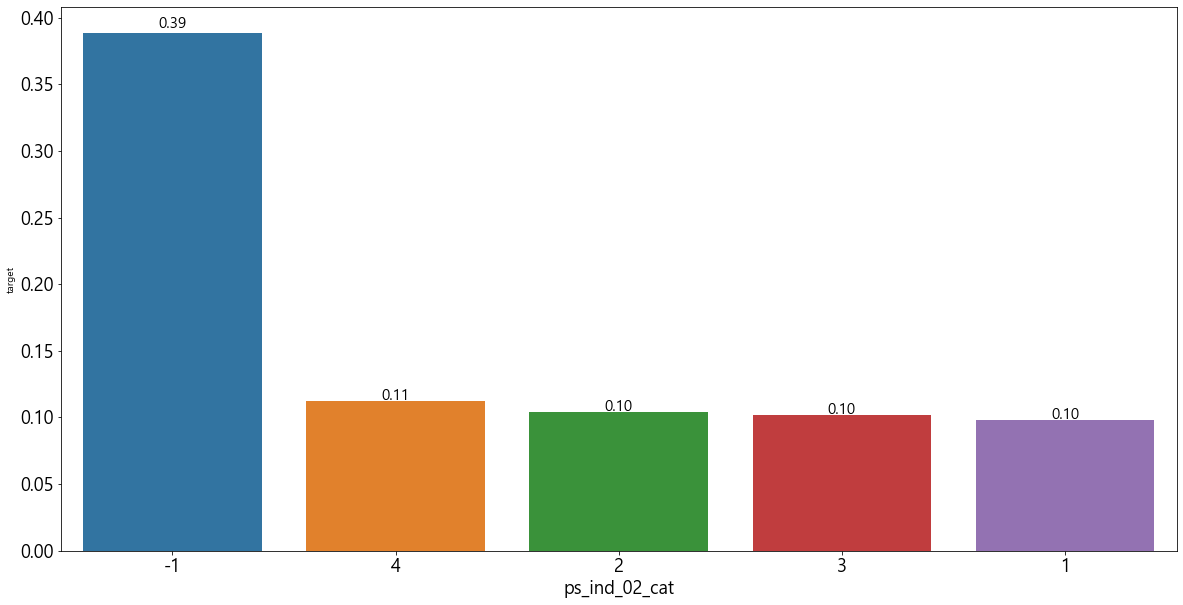

<Figure size 432x288 with 0 Axes>

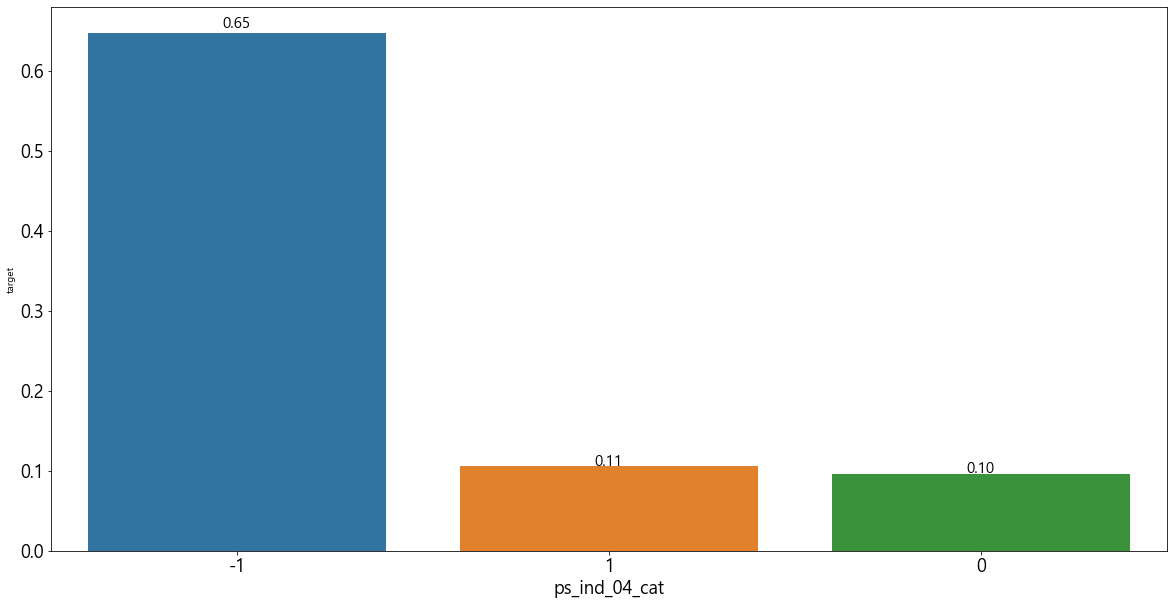

<Figure size 432x288 with 0 Axes>

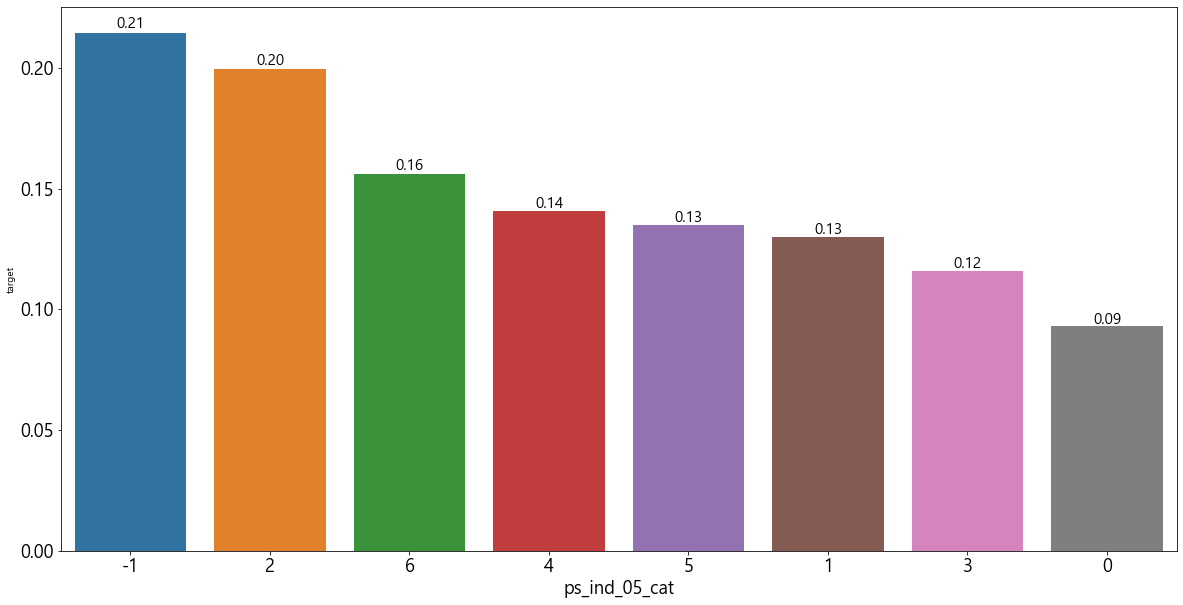

<Figure size 432x288 with 0 Axes>

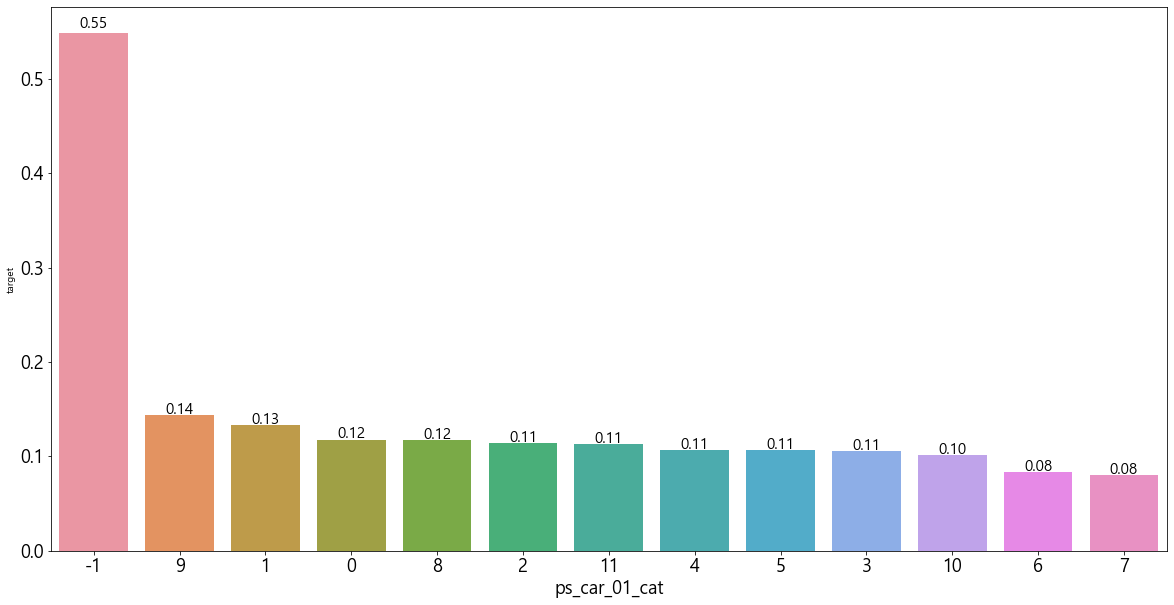

<Figure size 432x288 with 0 Axes>

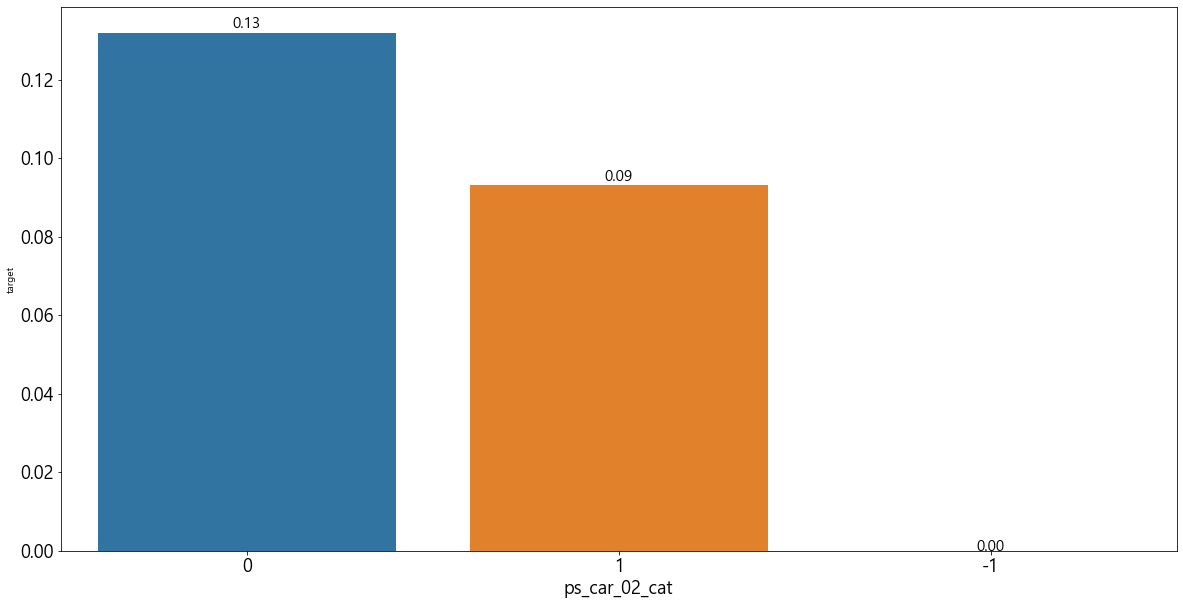

<Figure size 432x288 with 0 Axes>

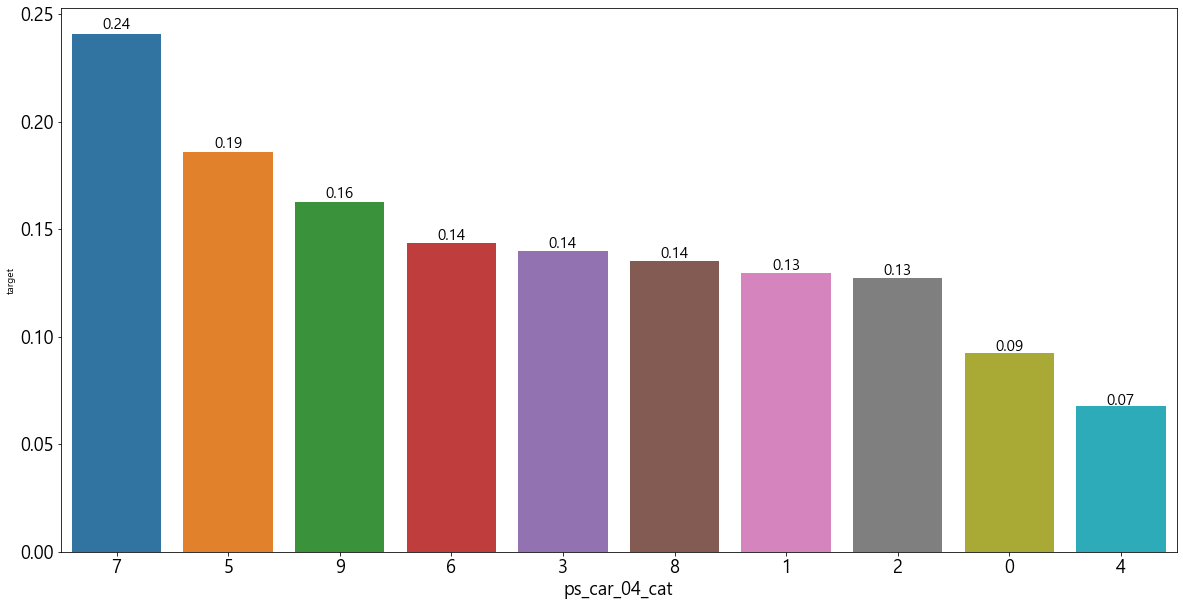

<Figure size 432x288 with 0 Axes>

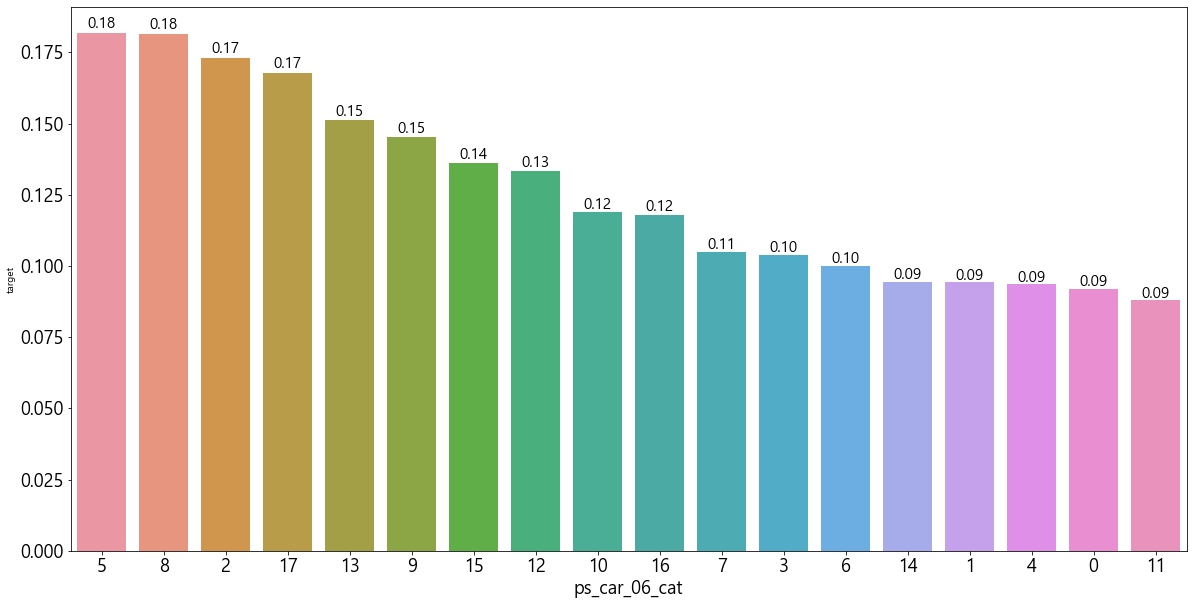

<Figure size 432x288 with 0 Axes>

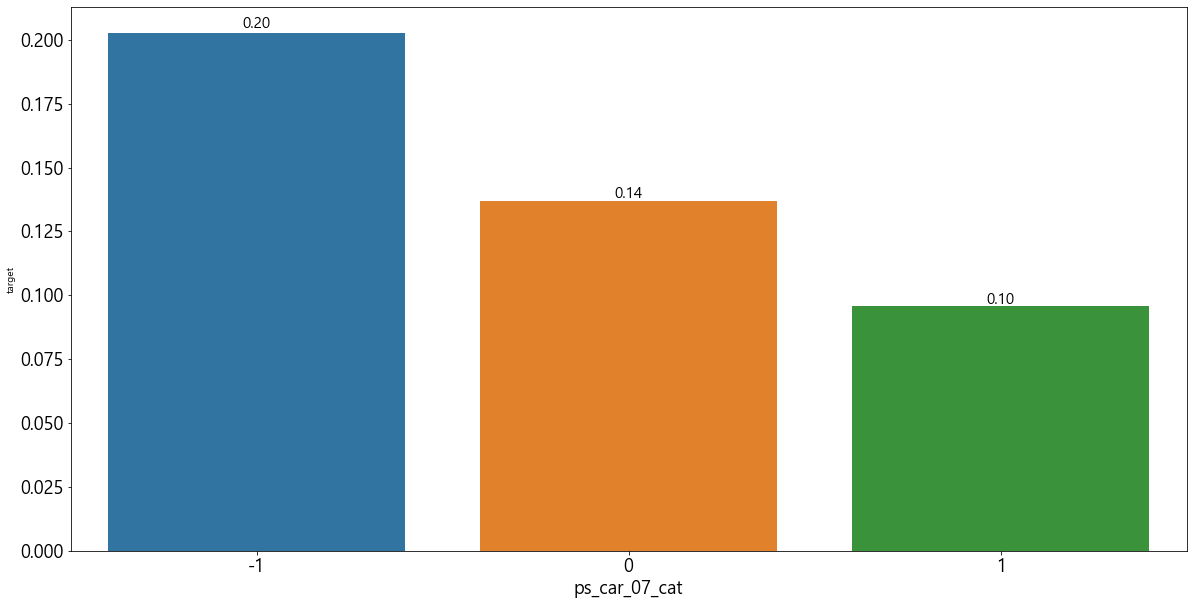

<Figure size 432x288 with 0 Axes>

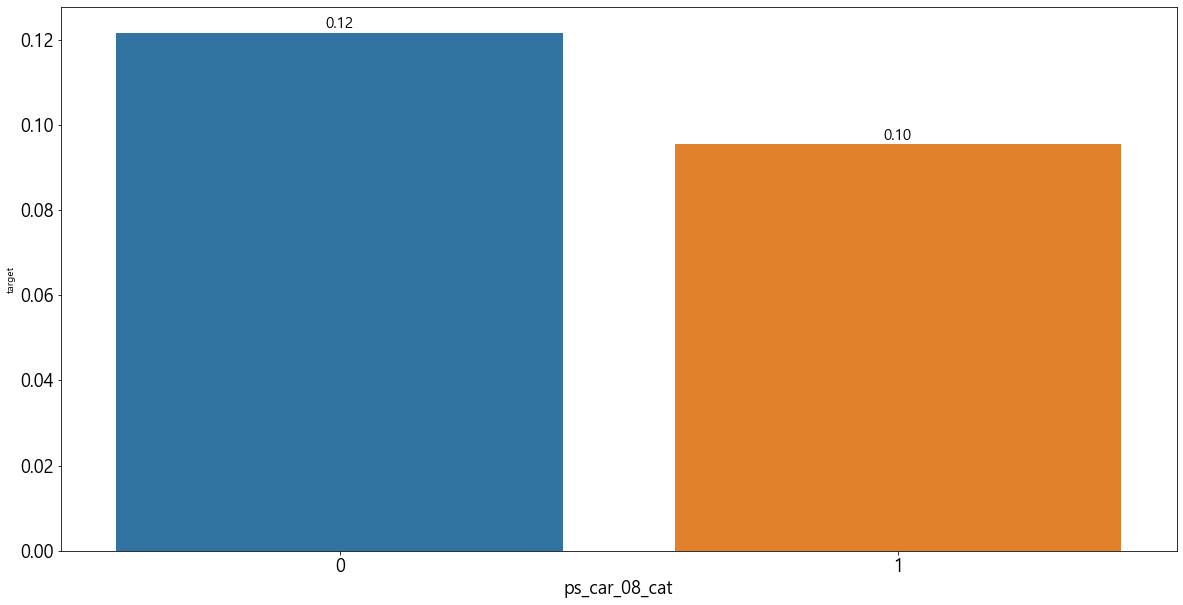

<Figure size 432x288 with 0 Axes>

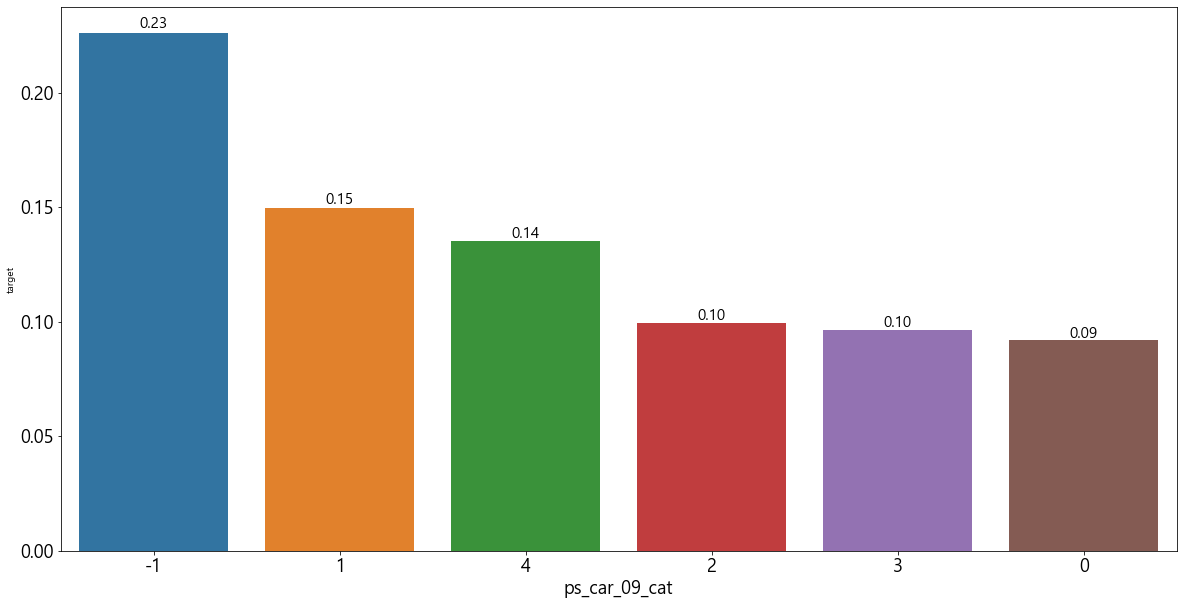

<Figure size 432x288 with 0 Axes>

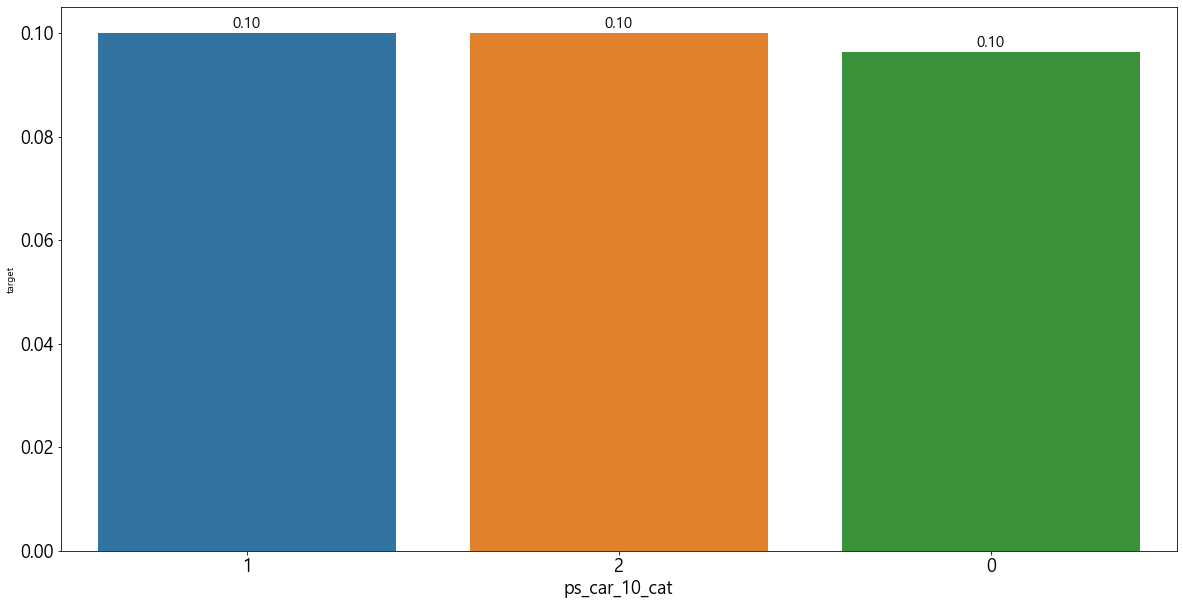

In [27]:
v= meta[(meta.level =='nominal') & (meta.keep)].index

for f in v:
    plt.figure()
    fig, ax= plt.subplots(figsize= (20, 10))
    # category 값마다 target=1의 값을 가진 비율을 계산
    cat_perc= train[[f, 'target']].groupby([f], as_index= False).mean()
    cat_perc.sort_values(by= 'target', ascending= False, inplace= True)
    # Bar plot
    # target의 평균의 내림차순으로 bar들을 정렬
    sns.barplot(ax=ax, x=f, y='target', data=cat_perc, order=cat_perc[f])
    plt.xlabel(f, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    for p in ax.patches:
        left, bottom, width, height= p.get_bbox().bounds
        ax.annotate("%.2f"%(height), (left+width/2, height*1.01), ha='center', fontsize=15)
    plt.show();

막대 그래프를 통해 **결측치가 있는** 변수들을 확인할 수 있습니다.  
몇몇 변수들의 결측치 비율이 상당함으로 우리는 이를 따로 치환하지 않겠습니다.  
트리 계열의 알고리즘을 적용할 경우, 결측치를 하나의 값으로써 볼 때에 이를 타 통계량으로 치환하는 것보다 더 좋은 성능을 나타낼 수 있습니다.  

<br>

더불어 결측치를 가지고 있는 Customer들이 다른 Value들에 비하여 훨씬 높은 target평균을 가지고 있기 때문에  
결측치 자체를 분리된 category value로써 보는 것이 좋은 방법일 수 있습니다.


## 6_2. Interval variables간의 상관관계
interval variable(간격형 변수)의 상관관계를 확인하고자 합니다.  
Heatmap은 Variables간의 상관관계를 확인하는데 매우 효율적입니다.

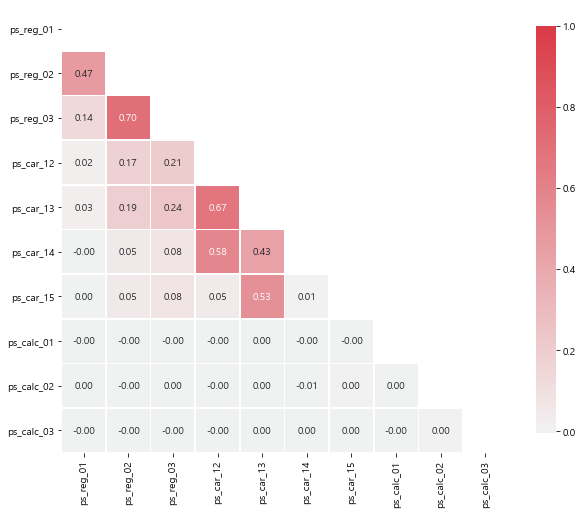

In [34]:
def corr_heatmap(v):
    correlations= train[v].corr()
    mask= np.triu(np.ones_like(correlations, dtype=bool))
    # 두 색상의 그라데이션 색상을 만듭니다.
    cmap= sns.diverging_palette(220, 10, as_cmap=True)
    
    fig, ax= plt.subplots(figsize= (10, 10))
    sns.heatmap(correlations, cmap= cmap, vmax= 1.0, center= 0, fmt= '.2f', mask= mask,
                square= True, linewidths= .5, annot= True, cbar_kws= {'shrink': .75})
    plt.show();
    
v= meta[(meta.level == 'interval') & (meta.keep)].index
corr_heatmap(v)

- 강한 상관관계를 가지고 있는 Variable들은 다음과 같습니다.
    - ps_reg_02 & ps_reg_03 **(0.7)**
    - ps_reg_12 & ps_reg_13 **(0.67)**
    - ps_reg_12 & ps_reg_14 **(0.58)**
    - ps_reg_13 & ps_reg_15 **(0.53)**  

<br>

Seaborn의 *pair plot*을 사용하면 variable들의 선형관계를 손쉽게 시각화할 수 있습니다.  
하지만 히트맵이 상관관계가 있는 variable들의 관계들을 시각화해주고 있기 때문에, 우리는 높은 상관관계를 보이는 variable들을 분리해서 보고자 합니다.  
**Note** 프로세스의 속도를 높이기 위하여 train 데이터의 sample을 사용합니다.

In [35]:
# train 데이터에서 10%의 데이터를 샘플링합니다.
s= train.sample(frac=0.1)

print('train.shape:', train.shape)
print('s.shape:', s.shape)

train.shape: (216940, 57)
s.shape: (21694, 57)


### (1) ps_reg_02 and ps_reg_03 (0.7)


회귀선이 보여주듯이, 두 variables들 간에는 선형 상관관계를 살펴볼 수 있습니다.  
*hue*파라미터를 통해 target=0과 target=1에 대한 회귀선이 동일함을 알 수 있습니다.

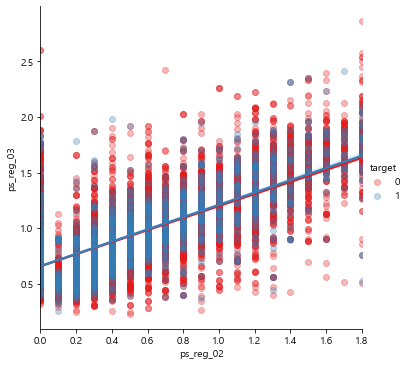

In [37]:
sns.lmplot(x= 'ps_reg_02', y= 'ps_reg_03', data=s, 
           hue= 'target', palette='Set1', scatter_kws= {'alpha': 0.3})
plt.show()

### (2) ps_car_12 and ps_car_13 (0.67)

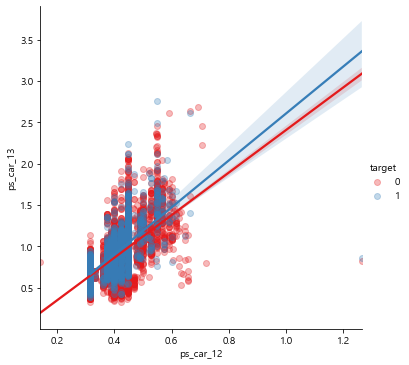

In [38]:
sns.lmplot(x='ps_car_12', y='ps_car_13', data=s, 
           hue= 'target', palette= 'Set1', scatter_kws={'alpha':0.3})
plt.show()

### (3) ps_car_12 and ps_car_14 (0.58)

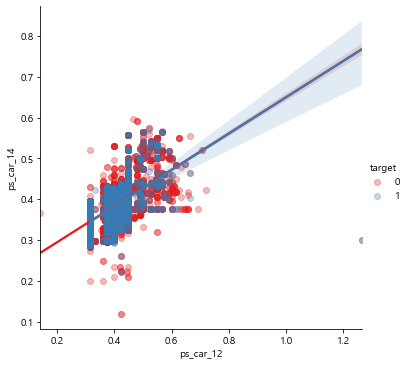

In [40]:
sns.lmplot(x='ps_car_12', y='ps_car_14', data=s, 
           hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

### (4) ps_car_13 and ps_car_15 (0.53)

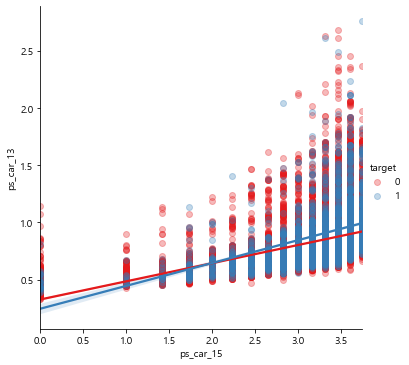

In [43]:
sns.lmplot(x= 'ps_car_15', y= 'ps_car_13', data= s,
           hue= 'target', palette='Set1', scatter_kws= {'alpha': 0.3})
plt.show()

이제는 어떤 correlated variables를 유지할지 결정해야 합니다.  
이를 위해서 우리는 Pricipal Component Analysis(PCA), 주성분 분석등을 실시하여 variables의 dimensions를 줄일 수 있습니다.  
하지만 correlated variables의 수가 적은 만큼, 우리는 모델이 heavy-lifting을 하도록 해야 합니다.

## 6_3 Ordinal variables간의 상관관계

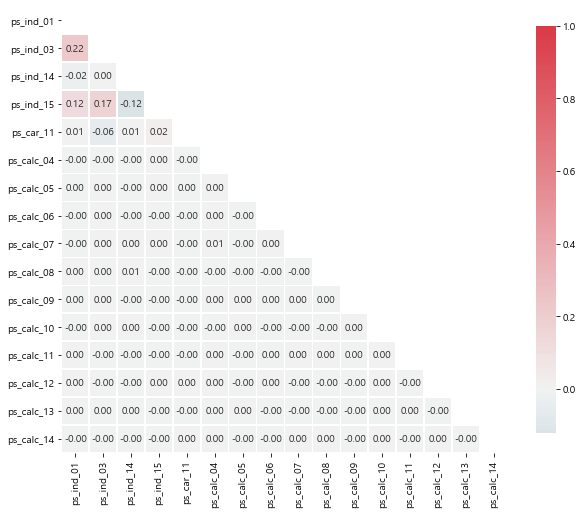

In [44]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
corr_heatmap(v)

Ordinal variables는 큰 상관관계를 가지고 있지 않는 것으로 보입니다.  
반면에 target값으로 그룹화할때 분포가 어떻게 될지 확인할 수 있습니다.

# 7. Feature engineering
## 7_1. dummy variables 생성
categorical variables는 어떤 순서나 중요도를 뜻하지 않습니다.  
예를 들어 카테고리 2는 카테고리 1보다 2배의 값을 가지고 있지 않습니다.  
하지만 많은 알고리즘들이 이를 크기로 생각하여 카테고리 2에 중요도를 더 부여할 수 있습니다.  
이 문제는 dummy 데이터를 만들어줌으로써 해결할 수 있습니다.  
첫 번째 dummy variable의 정보는 원래 variable의 범주에 대해 생성된 다른 dummy variable에서 파생될 수 있으므로 삭제해주도록 합니다.

In [45]:
v= meta[(meta.level == 'nominal') & (meta.keep)].index
print('dummification 하기전에 {}개의 변수가 train에 있었습니다.'.format(train.shape[1]))
train= pd.get_dummies(train, columns= v, drop_first= True)
print('dummification 한 후에 {}개의 변수가 train에 있습니다.'.format(train.shape[1]))

dummification 하기전에 57개의 변수가 train에 있었습니다.
dummification 한 후에 109개의 변수가 train에 있습니다.


# 7-2 interaction variables 생성

In [48]:
v= meta[(meta.level == 'interval') & (meta.keep)].index
poly= PolynomialFeatures(degree= 2, interaction_only= False, include_bias= False)
interactions= pd.DataFrame(data= poly.fit_transform(train[v]),
                           columns= poly.get_feature_names(v))

interactions.drop(v, axis= 1, inplace= True) # Poly 처리가 되지 않은 기존의 열들을 삭제

# interactions와 train 데이터를 합침
print('interaction 변수를 생성하기 전엔 train 데이터엔 {}개의 변수가 존재했습니다.'.format(train.shape[1]))
train= pd.concat([train, interactions], axis= 1)
print('interaction 변수를 생성한 후엔 train 데이터엔 {}개의 변수가 존재합니다.'.format(train.shape[1]))

interaction 변수를 생성하기 전엔 train 데이터엔 109개의 변수가 존재했습니다.
interaction 변수를 생성한 후엔 train 데이터엔 164개의 변수가 존재합니다.


PolynomialFeatures는 다항차수 변환을 진행을 도와주는 클래스입니다.  
상기 코드의 경우 degree을 2로 설정했으니 2차항 변수로 만들어주는 것입니다.  

<br>

이를 통해 train 데이터에 interaction variables를 추가할 수 있습니다. **get_feature_names** 메소드 덕분에 열 이름을 할당할 수 있습니다.

# 8. Feature selection
## 8_1. 낮은 variance를 가진 features를 지우기

작성자는 분류기의 알고리즘이 유지할 feature를 선택하는 것을 선호한다고 합니다. 하지만 우리 스스로 할 수 있는 일도 있습니다.  
분산이 0이거나 아주 적은 feature들을 제거하는 것입니다.  

<br>

이를 위해 사이킷런의 **VarianceThreshold**라는 메소드를 사용할 수 있습니다.  
기본적으로 이 메소드는 분산 값이 0인 feature들을 제거해줍니다.  

<br>

하지만 저희는 이전 단계에서 이미 분산이 0인 feature가 없음을 확인했기 때문에, 우리는 1% 미만의 분산이 있는 feature들을 제거해주고자 합니다.  
이를 통해 우리는 31개의 variable를 제거하게 됩니다.

In [50]:
selector= VarianceThreshold(threshold= .01)
selector.fit(train.drop(['id', 'target'], axis= 1))  # id와 target을 뺀 값만 fit함

VarianceThreshold(threshold=0.01)

In [53]:
f= np.vectorize(lambda x: not x) # Function to toggle boolean array elements
v= train.drop(['id', 'target'], axis=1).columns[f(selector.get_support())]
print('{}개의 변수들은 너무 낮은 variance를 가지고 있습니다.'.format(len(v)))
print('이 변수들은 {} 입니다.'.format(list(v)))

28개의 변수들은 너무 낮은 variance를 가지고 있습니다.
이 변수들은 ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_12', 'ps_car_14', 'ps_car_11_cat_te', 'ps_ind_05_cat_2', 'ps_ind_05_cat_5', 'ps_car_01_cat_1', 'ps_car_01_cat_2', 'ps_car_04_cat_3', 'ps_car_04_cat_4', 'ps_car_04_cat_5', 'ps_car_04_cat_6', 'ps_car_04_cat_7', 'ps_car_06_cat_2', 'ps_car_06_cat_5', 'ps_car_06_cat_8', 'ps_car_06_cat_12', 'ps_car_06_cat_16', 'ps_car_06_cat_17', 'ps_car_09_cat_4', 'ps_car_10_cat_1', 'ps_car_10_cat_2', 'ps_car_12^2', 'ps_car_12 ps_car_14', 'ps_car_14^2'] 입니다.


만약 우리가 분산에 기반하여 선택을 진행한다면 많은 variables을 잃게 될 것입니다.  
하지만 많은 variable을 가지고 있지 않기 때문에, 분류기가 직접 선택하도록 합니다.  
variable가 더 많은 데이터 셋이라면 처리 시간을 줄여줄 수 있을 것입니다.  

<br>

사이킷런은 [feature selection methods]를 제공합니다.  
이 메소드 중 하나가 'SelectFromModel'인데, 다른 분류기에서 최상의 feature를 선택하고 기능을 계속할 수 있도록 합니다.  
아래를 통해 랜덤포레스트를 어떻게 사용하는지 확인해보도록 합니다.

## 8_2. 랜덤포레스트와 SelectFromModel을 이용해 변수들을 선택하기
우리는 랜덤 포레스트의 feature importances에 따라 feature 선택의 기준을 삼습니다.  
SelectFromModel을 통하여 유지할 variables의 숫자를 구체화할 수 있습니다.  
feature의 중요도에 대한 임계값을 수동으로 설정할 수 있지만, 우리는 단순히 50% 이상의 최적의 variable를 선택해보도록 합시다.

In [56]:
X_train= train.drop(['id','target'], axis=1)
y_train= train['target']

feat_labels= X_train.columns

rf= RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

rf.fit(X_train, y_train)
importances= rf.feature_importances_

indices= np.argsort(rf.feature_importances_)[::-1]

for f in range(X_train.shape[1]):
    print('%2d) %-*s %f' % (f+1, 30, feat_labels[indices[f]], importances[indices[f]]))

 1) ps_car_11_cat_te               0.021254
 2) ps_car_13                      0.017323
 3) ps_car_12 ps_car_13            0.017246
 4) ps_car_13^2                    0.017208
 5) ps_car_13 ps_car_14            0.017162
 6) ps_reg_03 ps_car_13            0.017091
 7) ps_reg_01 ps_car_13            0.016742
 8) ps_car_13 ps_car_15            0.016722
 9) ps_reg_03 ps_car_14            0.016256
10) ps_reg_03 ps_car_12            0.015563
11) ps_reg_03 ps_car_15            0.015180
12) ps_car_14 ps_car_15            0.015050
13) ps_car_13 ps_calc_01           0.014718
14) ps_reg_01 ps_reg_03            0.014703
15) ps_car_13 ps_calc_03           0.014694
16) ps_car_13 ps_calc_02           0.014649
17) ps_reg_02 ps_car_13            0.014583
18) ps_reg_01 ps_car_14            0.014358
19) ps_reg_03                      0.014293
20) ps_reg_03^2                    0.014280
21) ps_reg_03 ps_calc_03           0.013816
22) ps_reg_03 ps_calc_02           0.013785
23) ps_reg_03 ps_calc_01        

In [57]:
sfm= SelectFromModel(rf, threshold= 'median', prefit=True)
print('Feature selection을 하기전의 feature의 갯수: {}'.format(X_train.shape[1]))
n_features= sfm.transform(X_train).shape[1]
print('Feature selection을 한 후의 feature의 갯수: {}'.format(n_features))
selected_vars= list(feat_labels[sfm.get_support()])

Feature selection을 하기전의 feature의 갯수: 162
Feature selection을 한 후의 feature의 갯수: 81


In [58]:
train= train[selected_vars + ['target']]

# 9. Feature scaling
이전에 언급했듯이, 우리는 train 데이터에 정규화를 진행할 수 있습니다.  
몇몇 분류기에서는 더 나은 결과를 가져올 수 있을 것입니다.

In [59]:
scaler= StandardScaler()
scaler.fit_transform(train.drop(['target'], axis=1))

array([[-0.45941104, -1.26665356,  1.05087653, ..., -0.72553616,
        -1.01071913, -1.06173767],
       [ 1.55538958,  0.95034274, -0.63847299, ..., -1.06120876,
        -1.01071913,  0.27907892],
       [ 1.05168943, -0.52765479, -0.92003125, ...,  1.95984463,
        -0.56215309, -1.02449277],
       ...,
       [-0.9631112 ,  0.58084336,  0.48776003, ..., -0.46445747,
         0.18545696,  0.27907892],
       [-0.9631112 , -0.89715418, -1.48314775, ..., -0.91202093,
        -0.41263108,  0.27907892],
       [-0.45941104, -1.26665356,  1.61399304, ...,  0.28148164,
        -0.11358706, -0.72653353]])

출처: 
[Bert Carremans 캐글 커널](https://www.kaggle.com/bertcarremans/data-preparation-exploration)